## Conv1D, using only osc and price data, 9 days

In [1]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [12]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [47]:
def read_data_files():
    data = pd.DataFrame()
    
    for filename in os.listdir('../data/UBC/'):
        if filename.endswith(".txt"): 
            # print('working on ', filename)
            tmp_df = pd.read_csv(os.path.join('../data/UBC/', filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            # symbol = filename.split("1")[0]
            # tmp_df = pd.concat([pd.Series([symbol] * tmp_df.shape[0], name = 'symbol'), tmp_df], axis=1)
            tmp_df = tmp_df.iloc[20:,:]
            tmp_df[180] = (tmp_df[179] + tmp_df[181])/2    # column 180 data is wrong, so replace it with mean value of column 179 and 181
            data = pd.concat([data, tmp_df])
    
    # adjust price data
    for i in range(118):
        data[235-i] = data[235-i]/data[118] 
        
    osc_names = ['osc' + str(i) for i in range(118)]
    prc_names = ['prc' + str(i) for i in range(118)]
    macd_names = ['macd' + str(i) for i in range(118)]
    data.columns = osc_names + prc_names + macd_names + ['rtn']
    
    osc_data = data.iloc[:, :118].reset_index(drop=True)
    osc_data = osc_data[osc_data.columns[::-1]]
    # osc_data = normalize_data(osc_data)
    
    prc_data = data.iloc[:, 118:236].reset_index(drop=True)
    prc_data = prc_data[prc_data.columns[::-1]]
    # prc_data = normalize_data(prc_data)
    
    macd_data = data.iloc[:, 236:354].reset_index(drop=True)
    macd_data = macd_data[macd_data.columns[::-1]]
    # macd_data = normalize_data(macd_data) 
    
    rtn = data['rtn'].reset_index(drop=True)
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    
    # data = pd.concat([osc_data, prc_data, macd_data, rtn, label], axis=1)
    data = pd.concat([osc_data, prc_data, rtn, label], axis=1)
    data = data.reset_index(drop=True)
    
    return data

In [4]:
def remove_duplicates(data):
    # target_names = list(data.columns)
    # del target_names[0]
    clean_data = data.drop_duplicates()
    clean_data= clean_data.reset_index(drop=True)
    return clean_data

In [5]:
def remove_extreme_values(data): 
    data = data[(data['osc1'] > -7) & (data['osc1'] < 7)] 
    data = data.reset_index(drop=True)
    return data

In [6]:
def remove_pos_values(data):
    data = data[data['osc1'] < 0]
    data = data.reset_index(drop=True)
    return data

In [17]:
def calc_derivative(data, name):
    derivatives = []
    for i in range(data.shape[0]):
        i_derivative = list(np.gradient(pd.Series(data.iloc[i,:])))
        derivatives.append(i_derivative)
    
    names = []
    for i in range(data.shape[1]):
        names.append(name + "_d"+ str(40-i)) 
    
    return pd.DataFrame(derivatives, columns=names, index=data.index)

In [18]:
def add_derivatives(data):
    osc = data.iloc[:, :118]
    # prc = data.iloc[:, 118:236]
    # macd = data.iloc[:, 236:354]
    
    rtn = data['rtn']
    label = data['label'] 
    
    osc_drv = calc_derivative(osc, 'osc')
    # prc_drv = calc_derivative(prc, 'prc')
    # macd_drv = calc_derivative(macd, 'macd')
    
    data = pd.concat([osc, osc_drv, rtn, label], axis=1)
    return data

In [7]:
class StockData():
    def __init__(self, data):

        # balance the data set 
        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        if pos_data.shape[0] > neg_data.shape[0]:
            pos_data = pos_data.sample(neg_data.shape[0])
        else:
            neg_data = neg_data.sample(pos_data.shape[0])
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
        
        X = data.iloc[:, :-1]
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [48]:
data = read_data_files()
data = remove_duplicates(data) 
data = remove_extreme_values(data)
data = remove_pos_values(data)
print(data.shape)
# print(data.columns.values)

(49109, 238)


In [49]:
stock_data = StockData(data)
print(stock_data.X_train.shape)
print(stock_data.X_valid.shape)
print(stock_data.X_test.shape)

(22774, 236)
(7592, 236)
(10122, 236)


In [50]:
# check how balanced are the three data sets
print(sum(stock_data.y_train)/stock_data.y_train.shape[0])
print(sum(stock_data.y_valid)/stock_data.y_valid.shape[0])
print(sum(stock_data.y_test)/stock_data.y_test.shape[0])

0.4990778958461403
0.5040832455216017
0.49901205295396167


In [51]:
X_train = np.array(stock_data.X_train).reshape(stock_data.X_train.shape[0], 2, 118)
y_train = to_categorical(stock_data.y_train)
X_valid = np.array(stock_data.X_valid).reshape(stock_data.X_valid.shape[0], 2, 118)
y_valid = to_categorical(stock_data.y_valid)
X_test = np.array(stock_data.X_test).reshape(stock_data.X_test.shape[0], 2, 118)
y_test = to_categorical(stock_data.y_test)

In [52]:
X_train = np.transpose(X_train, (0, 2, 1))
X_valid = np.transpose(X_valid, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

In [53]:
model = Sequential()
model.add(Conv1D(32, kernel_size=6, input_shape=(118, 2), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=6, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, verbose=0, validation_data=(X_valid, y_valid))

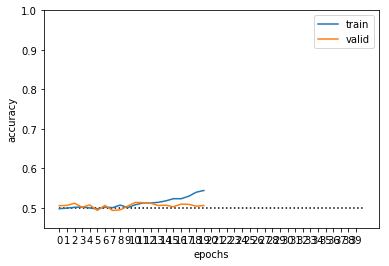

In [54]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 40, linestyles='dotted')
plt.ylim(0.45, 1)
plt.xticks(range(0, 40))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [55]:
scores = model.evaluate(X_valid, y_valid, verbose=1)
scores

7592/7592 [==============================] - 1s 115us/step


[0.7015084672652507, 0.5063224446786091]

In [56]:
pred = model.predict(X_valid)
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, stock_data.y_valid.reset_index(drop = True), stock_data.valid_rtn.reset_index(drop = True)], 
                    axis = 1)
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
pred_prob_level,,,,,
0.00,0.015476,0.200000,-1.536000,5,0.065859
0.05,0.080259,0.500000,0.450000,10,0.131718
0.10,0.140198,0.125000,-2.400000,8,0.105374
0.15,0.178759,0.600000,0.592000,15,0.197576
0.20,0.236987,0.400000,1.203000,10,0.131718
0.25,0.275115,0.550000,0.146750,40,0.526870
0.30,0.327662,0.505618,0.659888,89,1.172287
0.35,0.377811,0.502165,0.270216,231,3.042677
0.40,0.428876,0.497427,0.344494,583,7.679136


In [57]:
model = Sequential()
model.add(Conv1D(32, kernel_size=6, input_shape=(118, 2), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=6, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, verbose=0, validation_data=(X_test, y_test))

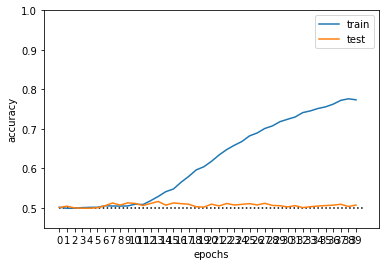

In [58]:
# results using training set and test set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 40, linestyles='dotted')
plt.ylim(0.45, 1)
plt.xticks(range(0, 40))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test']);

In [59]:
scores = model.evaluate(X_test, y_test, verbose=1)
scores

10122/10122 [==============================] - 1s 140us/step


[1.394798054251834, 0.5076071922427179]

In [60]:
pred = model.predict(X_test)
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, stock_data.y_test.reset_index(drop = True), stock_data.test_rtn.reset_index(drop = True)], 
                    axis = 1)
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
pred_prob_level,,,,,
0.00,0.011760,0.462758,0.314501,1262,12.467892
0.05,0.074249,0.545692,0.556919,383,3.783837
0.10,0.124132,0.446809,-0.033936,282,2.786011
0.15,0.174457,0.520408,0.348095,294,2.904564
0.20,0.225660,0.506623,0.459669,302,2.983600
0.25,0.276220,0.469914,0.152464,349,3.447935
0.30,0.326446,0.476998,0.150194,413,4.080221
0.35,0.375388,0.534591,0.325870,477,4.712507
0.40,0.425417,0.496667,0.156500,600,5.927682
